# Chapter 6

## Initial Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Initial imports.
import os
import sys
import zipfile
import time
import tiktoken
import torch

import numpy as np
import pandas as pd

from pathlib import Path

from typing import List, Dict, Any

import urllib.request

from matplotlib import pyplot as plt
from importlib.metadata import version
from torch.utils.data import Dataset, DataLoader

In [3]:
ancillar_path = "/llm_app/notebooks/build_large_language_models_from_scratch/"

if ancillar_path not in sys.path:
    sys.path.append(ancillar_path)

import ancillar as aux

In [4]:
# Show the version of the packages we are using.
pkgs = [
    "matplotlib",  # Plotting library.
    "numpy",  # PyTorch & TensorFlow dependency.
    "tiktoken",  # Tokenizer.
    "torch",  # Deep learning library.
    "tensorflow",  # For OpenAI's pretrained weights.
    "pandas",  # Dataset loading.
]

for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.10.0
numpy version: 1.26.3
tiktoken version: 0.8.0
torch version: 2.5.1+cpu
tensorflow version: 2.19.0
pandas version: 2.2.3


## Preparing the Dataset

In [5]:
url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = (
    "/llm_app/notebooks/build_large_language_models_from_scratch/sms_spam_collection"
)
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

In [6]:
def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    """
    Listing 6.1 Downloading and unzipping the dataset.
    """

    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    # Downloading the file.
    with urllib.request.urlopen(url) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    # Unzipping the file.
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # Add .tsv file extension.
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

In [7]:
try:
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)
except (urllib.error.HTTPError, urllib.error.URLError, TimeoutError) as e:
    print(f"Primary URL failed: {e}. Trying backup URL...")
    url = "https://f001.backblazeb2.com/file/LLMs-from-scratch/sms%2Bspam%2Bcollection.zip"
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

/llm_app/notebooks/build_large_language_models_from_scratch/sms_spam_collection/SMSSpamCollection.tsv already exists. Skipping download and extraction.


In [8]:
df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])

# Show it.
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [9]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


In [10]:
print(df["Label"].value_counts() / df.shape[0] * 100)

Label
ham     86.593683
spam    13.406317
Name: count, dtype: float64


In [11]:
def create_balanced_dataset(df):
    """
    Listing 6.2 Creating a balanced dataset.
    """

    # Count the instances of "spam".
    num_spam = df[df["Label"] == "spam"].shape[0]

    # Randomly sample "ham" instances to match the number of "spam" instances.
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)

    # Combine ham "subset" with "spam".
    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])

    return balanced_df

In [12]:
balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


In [13]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

In [14]:
train_df, validation_df, test_df = aux.random_split(balanced_df, 0.7, 0.1)

In [15]:
train_file_path = "/llm_app/notebooks/build_large_language_models_from_scratch/sms_spam_collection/train.csv"
validation_file_path = "/llm_app/notebooks/build_large_language_models_from_scratch/sms_spam_collection/validation.csv"
test_file_path = "/llm_app/notebooks/build_large_language_models_from_scratch/sms_spam_collection/test.csv"

train_df.to_csv(train_file_path, index=None)
validation_df.to_csv(validation_file_path, index=None)
test_df.to_csv(test_file_path, index=None)

In [16]:
print(train_df["Label"].value_counts())

Label
0    528
1    517
Name: count, dtype: int64


In [17]:
print(validation_df["Label"].value_counts())

Label
1    79
0    70
Name: count, dtype: int64


In [18]:
print(test_df["Label"].value_counts())

Label
1    151
0    149
Name: count, dtype: int64


## Creating Data Loaders

In [19]:
tokenizer = tiktoken.get_encoding("gpt2")
print(
    tokenizer.encode(
        "<|endoftext|> Parrots are green because they descend from dinossaurs <|endoftext|>",
        allowed_special={"<|endoftext|>"},
    )
)

[50256, 2547, 24744, 389, 4077, 780, 484, 15350, 422, 16278, 793, 64, 1834, 220, 50256]


In [20]:
type(tokenizer)

tiktoken.core.Encoding

In [21]:
train_dataset = aux.SpamDataset(
    csv_file=train_file_path, max_length=None, tokenizer=tokenizer
)

# Show the largest encoded length.
print(train_dataset.max_length)

120


In [22]:
val_dataset = aux.SpamDataset(
    csv_file=validation_file_path,
    max_length=train_dataset.max_length,
    tokenizer=tokenizer,
)
test_dataset = aux.SpamDataset(
    csv_file=test_file_path, max_length=train_dataset.max_length, tokenizer=tokenizer
)

In [23]:
torch.manual_seed(123)

num_workers: int = 0  # This setting ensures compatibility with most computers.
batch_size: int = int(1 * 8)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    drop_last=False,
)

In [24]:
for input_batch, target_batch in train_loader:
    pass

print(">>> Input batch dimensions:", input_batch.shape)
print(">>> Label batch dimensions:", target_batch.shape)

>>> Input batch dimensions: torch.Size([8, 120])
>>> Label batch dimensions: torch.Size([8])


In [25]:
print(f">>> {len(train_loader)} training batches ...")
print(f">>> {len(val_loader)} validation batches ...")
print(f">>> {len(test_loader)} test batches ...")

>>> 130 training batches ...
>>> 19 validation batches ...
>>> 38 test batches ...


## Initializing a Model with Pretrained Weights

In [26]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,  # Vocabulary size.
    "context_length": 1024,  # Context length.
    "drop_rate": 0.0,  # Dropout rate.
    "qkv_bias": True,  # Query-key-value bias.
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

print(f">>> Base configuration:\n\t{BASE_CONFIG}")

assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"Dataset length {train_dataset.max_length} exceeds model's context "
    f"length {BASE_CONFIG['context_length']}. Reinitialize data sets with "
    f"`max_length={BASE_CONFIG['context_length']}`"
)

>>> Base configuration:
	{'vocab_size': 50257, 'context_length': 1024, 'drop_rate': 0.0, 'qkv_bias': True, 'emb_dim': 768, 'n_layers': 12, 'n_heads': 12}


In [27]:
url = (
    "https://raw.githubusercontent.com/rasbt/"
    "LLMs-from-scratch/main/ch05/"
    "01_main-chapter-code/gpt_download.py"
)

filename = url.split("/")[-1]
urllib.request.urlretrieve(url, filename)

from gpt_download import download_and_load_gpt2

2025-06-13 15:41:35.538166: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-13 15:41:35.542054: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-13 15:41:35.553353: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749829295.572652    1177 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749829295.578365    1177 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749829295.593120    1177 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [28]:
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
model_size

settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = aux.GPTModel(BASE_CONFIG)
aux.load_weights_into_gpt(model, params)

# In evaluation mode, dropout layers are disabled and the model
# behaves deterministically.
_ = model.eval();

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


In [29]:
text_1 = "Every effort moves you"

token_ids = aux.generate_text_simple(
    model=model,
    idx=aux.text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"],
)

print(aux.token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


In [30]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)

token_ids = aux.generate_text_simple(
    model=model,
    idx=aux.text_to_token_ids(text_2, tokenizer),
    max_new_tokens=75,
    context_size=BASE_CONFIG["context_length"],
)

print(aux.token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $


## Adding a Classification Head

In [31]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [32]:
# Make all layers nontrainable. Freeze the model.
for param in model.parameters():
    param.requires_grad = False

In [33]:
torch.manual_seed(123)
num_classes = 2

# This new `model.out_head` output layer has its `requires_grad` attribute set to True by default,
# which means that it’s the only layer in the model that will be updated during training.
model.out_head = torch.nn.Linear(
    in_features=BASE_CONFIG["emb_dim"], out_features=num_classes, bias=True
)

In [34]:
# Last transformer block trainable.
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

# Last normalization layer trainable.
for param in model.final_norm.parameters():
    param.requires_grad = True

In [35]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)

print(">>> Inputs:", inputs)
print(">>> Inputs dimensions:", inputs.shape)  # shape: (batch_size, num_tokens)

>>> Inputs: tensor([[5211,  345,  423,  640]])
>>> Inputs dimensions: torch.Size([1, 4])


In [36]:
# Forward pass through the model.
with torch.no_grad():
    outputs = model(inputs)

print(">>> Outputs:\n", outputs)
print(">>> Outputs dimensions:", outputs.shape)

>>> Outputs:
 tensor([[[-1.5847,  0.9897],
         [-3.7233,  7.4538],
         [-2.2661,  6.6043],
         [-3.5980,  3.9901]]])
>>> Outputs dimensions: torch.Size([1, 4, 2])


In [37]:
print(">>> Last output token:", outputs[:, -1, :])

>>> Last output token: tensor([[-3.5980,  3.9901]])


### Exercise 6.2: Fine-tuning the Whole Model

### Exercise 6.3: Fine-tuning The First vs. Last Token

## Calculating the Classification Loss and Accuracy

In [38]:
probas = torch.softmax(outputs[:, -1, :], dim=-1)
label = torch.argmax(probas)
print(">>> Class label:", label.item())

>>> Class label: 1


In [39]:
device: str = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f">>> Running on {device} device.")

model.to(device)

# For reproducibility due to the shuffling in the training data loader.
torch.manual_seed(123)

train_accuracy = aux.calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = aux.calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = aux.calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f">>> Training accuracy: {train_accuracy*100:.2f}%")
print(f">>> Validation accuracy: {val_accuracy*100:.2f}%")
print(f">>> Test accuracy: {test_accuracy*100:.2f}%")

>>> Running on cpu device.
>>> Training accuracy: 46.25%
>>> Validation accuracy: 45.00%
>>> Test accuracy: 48.75%


In [40]:
# No grad means that we are not calculating gradients, which saves memory and speeds up the computation.
with torch.no_grad():

    # Calculate the loss for the training, validation, and test sets.
    # Note: num_batches is set to 5 for faster computation in this example.
    # In practice, you might want to set it to the total number of batches.
    train_loss = aux.calc_loss_loader(
        data_loader=train_loader, model=model, device=device, num_batches=5
    )
    val_loss = aux.calc_loss_loader(
        data_loader=val_loader, model=model, device=device, num_batches=5
    )
    test_loss = aux.calc_loss_loader(
        data_loader=test_loader, model=model, device=device, num_batches=5
    )

print(f">>> Training loss: {train_loss:.3f}")
print(f">>> Validation loss: {val_loss:.3f}")
print(f">>> Test loss: {test_loss:.3f}")

>>> Training loss: 2.454
>>> Validation loss: 2.584
>>> Test loss: 2.323


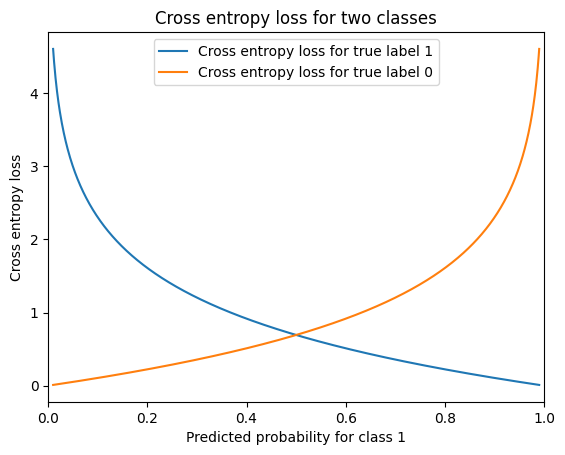

In [41]:
# Cross entropy for two classes.
pp = np.linspace(0.01, 0.99, 1000)
pn = 1 - pp
ps = np.stack([pp, pn], axis=1)
cross_entropy_loss1 = (-1) * (1 * np.log(pp) + (1 - 1) * np.log(1 - pp))
cross_entropy_loss0 = (-1) * (0 * np.log(pp) + (1 - 0) * np.log(1 - pp))
plt.plot(pp, cross_entropy_loss1, label=f"Cross entropy loss for true label {1}")
plt.plot(pp, cross_entropy_loss0, label=f"Cross entropy loss for true label {0}")
plt.xlabel("Predicted probability for class 1")
plt.ylabel("Cross entropy loss")
plt.title("Cross entropy loss for two classes")
plt.xlim(0, 1)
plt.legend();

## Fine-tuning the Model on Supervised Data

In [42]:
start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(params=model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs: int = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = (
    aux.train_classifier_simple(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        device=device,
        num_epochs=num_epochs,
        eval_freq=50,
        eval_iter=5,
    )
)
end_time = time.time()

execution_time_minutes = (end_time - start_time) / 60.0
print(f">>> Training completed in {execution_time_minutes:.2f} minutes.")

>>> Ep 1 (Step  00000): Train loss 2.154, Val loss 2.393
>>> Ep 1 (Step  00050): Train loss 0.617, Val loss 0.637
>>> Ep 1 (Step  00100): Train loss 0.523, Val loss 0.557
>>> Training accuracy:  70.00% | Validation accuracy:  72.50%
>>> Ep 2 (Step  00150): Train loss 0.561, Val loss 0.489
>>> Ep 2 (Step  00200): Train loss 0.419, Val loss 0.397
>>> Ep 2 (Step  00250): Train loss 0.409, Val loss 0.353
>>> Training accuracy:  82.50% | Validation accuracy:  85.00%
>>> Ep 3 (Step  00300): Train loss 0.333, Val loss 0.320
>>> Ep 3 (Step  00350): Train loss 0.338, Val loss 0.303
>>> Training accuracy:  90.00% | Validation accuracy:  90.00%
>>> Ep 4 (Step  00400): Train loss 0.129, Val loss 0.191
>>> Ep 4 (Step  00450): Train loss 0.150, Val loss 0.128
>>> Ep 4 (Step  00500): Train loss 0.221, Val loss 0.133
>>> Training accuracy:  100.00% | Validation accuracy:  97.50%
>>> Ep 5 (Step  00550): Train loss 0.206, Val loss 0.141
>>> Ep 5 (Step  00600): Train loss 0.081, Val loss 0.073
>>> Traini

In [43]:
def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):

    fig, ax1 = plt.subplots(figsize=(9, 3))

    # Plot training and validation loss against epochs.
    ax1.plot(epochs_seen, train_values, marker=".", label=f"Training {label}")
    ax1.plot(
        epochs_seen, val_values, marker=".", linestyle="-.", label=f"Validation {label}"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen.
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis.
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks.
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()
    plt.show()

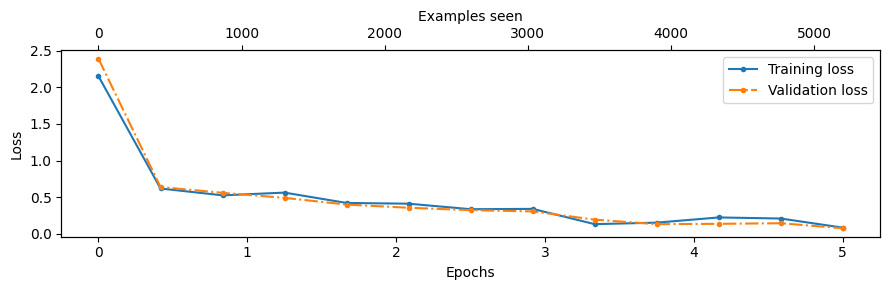

In [44]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

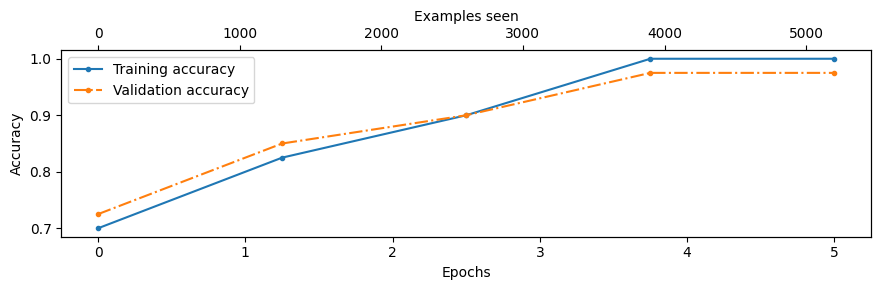

In [45]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

In [46]:
train_accuracy = aux.calc_accuracy_loader(train_loader, model, device)
val_accuracy = aux.calc_accuracy_loader(val_loader, model, device)
test_accuracy = aux.calc_accuracy_loader(test_loader, model, device)

print(f">>> Training accuracy: {train_accuracy * 100:.2f}%")
print(f">>> Validation accuracy: {val_accuracy * 100:.2f}%")
print(f">>> Test accuracy: {test_accuracy * 100:.2f}%")

>>> Training accuracy: 97.21%
>>> Validation accuracy: 97.32%
>>> Test accuracy: 95.67%


## Using the LLM as a Spam Classifier